In [2]:
#Mount to google drive
from google.colab import drive
drive.mount('/content/drive') 


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 https://cloud.r-project.org/bin/linux/ubuntu bi

In [4]:
!wget -q https://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz

In [5]:
!tar xf spark-3.0.1-bin-hadoop2.7.tgz

In [6]:
#Setting enviroment varibles
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

In [7]:
!pip install sympy

In [8]:
!pip install findspark

In [9]:
#Locating spark so can be use in google colab
import findspark# py -m pip install findspark
findspark.init()
print(findspark.find())

/content/spark-3.0.1-bin-hadoop2.7


In [10]:
#createing spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Statistical_Analysis")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

spark #outputs spark session details

In [11]:
#Accessing data
#path: /content/drive/MyDrive/UNI/Year 3/Full Unit Project/Data/sensor-fault-detection.csv
df = spark.read.csv("sensor-fault-detection.csv", header = True, inferSchema = True)
df.show(5) # data not in ideal format.

+------------------------+
|Timestamp;SensorId;Value|
+------------------------+
|    2017-03-01T23:20:...|
|    2017-03-02T04:00:...|
|    2017-03-23T06:25:...|
|    2017-03-23T19:35:...|
|    2017-04-04T15:10:...|
+------------------------+
only showing top 5 rows



In [12]:
from sympy.ntheory import factorint
#formating data
#rdd = df.rdd #complicates the rdd set interms of formatting: includes row  structure
rdd = spark.sparkContext.textFile("sensor-fault-detection.csv")
#output
list = rdd.take(5)
print("Formatting...\n",list)

#formatting
rdd = rdd.map(lambda x: x.split(";"))

#remove first. For this case can do this way, no other row than the first filters
header = rdd.first()
rdd = rdd.filter(lambda x: x != header)

#convert 'SensorId' to int & 'Value' to in float
rdd = rdd.map(lambda x: (x[0],int(x[1]),float(x[2])))

#output
list = rdd.take(5)
print("Typeing...\nResult:\n",list)

Formatting...
 ['Timestamp;SensorId;Value', '2017-03-01T23:20:00+03:00;1;18.4798069', '2017-03-02T04:00:00+03:00;1;19.53911209', '2017-03-23T06:25:00+03:00;1;19.25019836', '2017-03-23T19:35:00+03:00;1;18.96128464']
Typeing...
Result:
 [('2017-03-01T23:20:00+03:00', 1, 18.4798069), ('2017-03-02T04:00:00+03:00', 1, 19.53911209), ('2017-03-23T06:25:00+03:00', 1, 19.25019836), ('2017-03-23T19:35:00+03:00', 1, 18.96128464), ('2017-04-04T15:10:00+03:00', 1, 25.32162285)]


In [13]:
#converting rdd to df 
df = rdd.toDF(header)# cant name the 4th column as i get an error
df.show(5)

+--------------------+--------+-----------+
|           Timestamp|SensorId|      Value|
+--------------------+--------+-----------+
|2017-03-01T23:20:...|       1| 18.4798069|
|2017-03-02T04:00:...|       1|19.53911209|
|2017-03-23T06:25:...|       1|19.25019836|
|2017-03-23T19:35:...|       1|18.96128464|
|2017-04-04T15:10:...|       1|25.32162285|
+--------------------+--------+-----------+
only showing top 5 rows



Now that the data in 'sensor-fault-detection.csv' has been formated we can now perform statistical analysis. Inorder to do so I am going to make use of sparks mllib module.

In [14]:
#Performing sttistical analyis on 'Value' columin in df before frequency disribuion
#using describe to find min, max, mean, standard deviation, count and range
from pyspark.sql import Row

statistics = df.describe(['Value'])

#calculateing range
min = statistics.filter(statistics['summary'] == 'min').collect()
max = statistics.filter(statistics['summary'] == 'max').collect()

range = spark.createDataFrame([('range', float(max[0].Value) - float(min[0].Value),)],['summary','Value'])

# output unoin of range and statistics
statistics = statistics.union(range)
statistics.show()

+-------+------------------+
|summary|             Value|
+-------+------------------+
|  count|             62629|
|   mean|24.203861068991316|
| stddev|  5.41159930162747|
|    min|       6.886154652|
|    max|       149.6018219|
|  range|142.71566724800002|
+-------+------------------+



In [15]:
#Frequecy distribution total
from pyspark.sql.functions import asc,desc,col
print("showing top 10 values:")
top = df.groupBy('Value').count().orderBy(col('count').desc()).show(10)

showing top 10 values:
+------------------+-----+
|             Value|count|
+------------------+-----+
|       26.96139145|  694|
|       23.68248367|  678|
|       27.15434837|  672|
|       27.05786133|  611|
|       26.86492348|  603|
|26.671985630000002|  581|
|       23.39327431|  574|
|       25.41807175|  573|
|       22.91132355|  569|
|       26.57551765|  567|
+------------------+-----+
only showing top 10 rows



Displaying frequency distribution....
+------------------+-----+
|             Value|count|
+------------------+-----+
|       6.886154652|    8|
|       6.981698036|   30|
|       7.077241421|   33|
|       7.172785282|   35|
|7.2683286670000005|   44|
|       7.363891602|   63|
|       7.459434986|   60|
|       7.554997921|   60|
|       7.650561333|   66|
|       7.746104717|   49|
|       7.841667652|   39|
|       7.937230587|   31|
|       8.032793999|   63|
|       8.128376961|   44|
|       8.223939896|   43|
|       8.319502831|   37|
|       8.415084839|   50|
|       8.510667801|   25|
|       8.606230736|   20|
|       8.701813698|   23|
+------------------+-----+
only showing top 20 rows

+-----------+-----+
|      Value|count|
+-----------+-----+
|149.6018219|    8|
| 38.4747963|    1|
|38.37757111|    1|
|38.18312073|    1|
|38.08591461|    3|
|37.98868942|    1|
|37.79425812|    2|
|  37.697052|   11|
|37.59982681|   17|
| 37.5026207|   20|
|37.40541458|   27|
|37.3082

(array([30., 25., 26., 36., 21., 17.,  8.,  5.,  7.,  3.,  5.,  4.,  7.,
         6.,  6.,  1.,  1.,  2.,  4.,  3.,  5.,  5.,  1.,  7.,  6.,  5.,
         8.,  7.,  0.,  5.,  7.,  4.,  3.,  1.,  2.,  8.,  2.,  6.,  5.,
         5.,  6.,  3.,  0.,  1.,  1.,  0.,  0.,  0.,  2.,  1.]),
 array([  1.  ,  14.86,  28.72,  42.58,  56.44,  70.3 ,  84.16,  98.02,
        111.88, 125.74, 139.6 , 153.46, 167.32, 181.18, 195.04, 208.9 ,
        222.76, 236.62, 250.48, 264.34, 278.2 , 292.06, 305.92, 319.78,
        333.64, 347.5 , 361.36, 375.22, 389.08, 402.94, 416.8 , 430.66,
        444.52, 458.38, 472.24, 486.1 , 499.96, 513.82, 527.68, 541.54,
        555.4 , 569.26, 583.12, 596.98, 610.84, 624.7 , 638.56, 652.42,
        666.28, 680.14, 694.  ]),
 <a list of 1 Patch objects>)

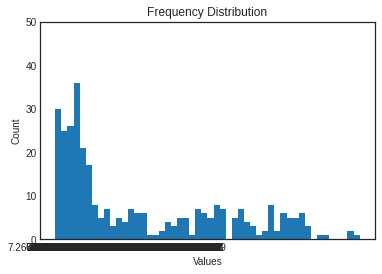

In [16]:
#Frequency display the distribution graphically!
print('Displaying frequency distribution....')
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import collect_list

#calculateing frequency distribution
frequency = df.groupBy('Value').count().orderBy(col('Value'))
frequency.show()
desc_df = df.groupBy('Value').count().orderBy(col('Value').desc())
desc_df.show()
#calculteing frequency stats - results in a slight change in  the mean- thats wy i decieded to show both
frequency_stats = frequency.describe(["Value"]).union(range)
frequency_stats.show()

#getting data from columns and removeing null values
data = frequency.select(collect_list('count')).first()[0]
data.pop(0)
labels = frequency.select(collect_list('Value')).first()[0]
labels.pop(0)  
plt.style.use('seaborn-white')
plt.title('Frequency Distribution')
plt.xlabel('Values')
plt.ylabel('Count')
plt.xticks(np.arange(len(labels)), labels)
plt.ylim(0,50)

#note can not see =m to get the y axis to scale
plt.hist(data, bins = 50,histtype='stepfilled')

Explantion for different loops in next block.
Seperate loop for labels and data as this:

while x <= 1:
  aprox_percentile_descriptions.append((str(int(x*100)),frequency.approxQuantile('Value',[float(x)],0)[0]))
  data.append(aprox_percentile_descriptions[int(x*10)-1][1])
  labels.append(aprox_percentile_descriptions int(x*10)-1][0])
  x += 0.1

  outputs this:

  [9.944543839, 13.38778782, 16.55446625, 19.63542366, 22.71856499, 25.90029716, 28.98782158, 28.98782158, 35.26742554, 35.26742554]

['10', '20', '30', '40', '50', '60', '70', '70', '89', '89']

  

+---------------+-----------+
|Percentile (th)|      Value|
+---------------+-----------+
|             10|9.944543839|
|             20|13.38778782|
|             30|16.55446625|
|             40|19.63542366|
|             50|22.71856499|
|             60|25.90029716|
|             70|28.98782158|
|             80|32.17411804|
|             89|35.26742554|
|             99|149.6018219|
+---------------+-----------+

[('10', 9.944543839), ('20', 13.38778782), ('30', 16.55446625), ('40', 19.63542366), ('50', 22.71856499), ('60', 25.90029716), ('70', 28.98782158), ('80', 32.17411804), ('89', 35.26742554), ('99', 149.6018219)]
[9.944543839, 13.38778782, 16.55446625, 19.63542366, 22.71856499, 25.90029716, 28.98782158, 32.17411804, 35.26742554, 149.6018219]
['10', '20', '30', '40', '50', '60', '70', '80', '89', '99']


<BarContainer object of 10 artists>

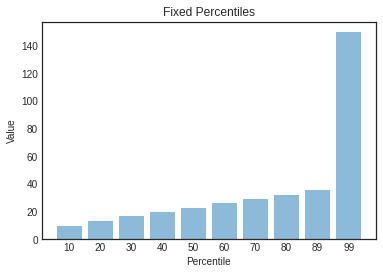

In [17]:
#Frequency distribution at fixed percentiles
aprox_percentile_descriptions = []
# graphial representation 
data = []
labels = []

'''
approxQuantile- calculate percetile
*x-A SparkDataFrame.
*col - The name of the numerical column.
*probabilities-A list of quantile probabilities. Each number must belong to [0, 1].
 For example 0 is the minimum, 0.5 is the median, 1 is the maximum.
*relativeError-The relative target precision to achieve (>= 0). If set to zero, 
 the exact quantiles are computed, which could be very expensive. Note that values
 greater than 1 are accepted but give the same result as 1.

'''
#exspensive
#calculateing percentiles
x = 0.1
while x <= 1:
  aprox_percentile_descriptions.append((str(int(x*100)),frequency.approxQuantile('Value',[float(x)],0)[0]))
  #data.append(aprox_percentile_descriptions[int(x*10)-1][1])
  #labels.append(aprox_percentile_descriptions[int(x*10)-1][0])
  x += 0.1

percentiles = spark.createDataFrame(aprox_percentile_descriptions,["Percentile (th)","Value"])
percentiles.show()

#setting up lables & data for visualisation

for i in aprox_percentile_descriptions:
  data.append(i[1]) 
  labels.append(i[0]) 

print(aprox_percentile_descriptions)
print(data)
print(labels)

#createing graphical representation
plt.style.use('seaborn-white')
plt.title('Fixed Percentiles')
plt.xlabel('Percentile')
plt.ylabel('Value')
plt.xticks(np.arange(len(labels)), labels)
plt.bar(np.arange(len(labels)),data, align = "center", alpha = 0.5)

In [18]:

import time
#Grouped Frequency Analysis 
#converting frequency distribution data frame into an rdd 
frequency_rdd = frequency.rdd.map(tuple)

global_distribution_data = []
j = 0
start = time.clock()
for i in data:
  print(i)
  #filtering values with in the class width
  group_distribution = frequency_rdd.filter(lambda x: x[0] <= i and x[0] > j)
 
  #key value pair (1, value frequency)
  group_distribution = group_distribution.map(lambda x: (1,x[1]))
  #print(group_distribution.take(5))
  #reduce by key adding all value frequencies with in a class width
  group_distribution = group_distribution.reduceByKey(lambda x,y:x+y)
  #print(group_distribution.take(5))
  group = group_distribution.collect()
  
  #storing results in an array for visualisation
  global_distribution_data.append(group[0][1])
  j = i

print("Processor time: ",time.clock() - start) 
print(global_distribution_data)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':


9.944543839
13.38778782
16.55446625
19.63542366
22.71856499
25.90029716
28.98782158
32.17411804
35.26742554
149.6018219
Processor time:  1.97588
[1137, 1723, 2645, 3763, 12396, 16651, 13805, 8122, 1765, 622]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


<BarContainer object of 10 artists>

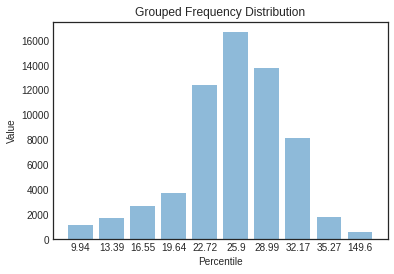

In [19]:
#Visualising the grouped Frequency distribution
labels = [round(i,2) for i in data]
plt.style.use('seaborn-white')
plt.title('Grouped Frequency Distribution')
plt.xlabel('Percentile')
plt.ylabel('Value')
plt.xticks(np.arange(len(labels)), labels)
plt.bar(np.arange(len(labels)),global_distribution_data, align = "center", alpha = 0.5)

In [20]:
#Median
median_val = percentiles.select(percentiles["Value"]).where(percentiles["Percentile (th)"] == 50).collect()
median = spark.createDataFrame([("median", median_val[0].Value)])
#median.show()
frequency_stats = frequency_stats.union(median)
frequency_stats.show()

+-------+------------------+
|summary|             Value|
+-------+------------------+
|  count|               324|
|   mean| 23.06364438853085|
| stddev|11.494495307961405|
|    min|       6.886154652|
|    max|       149.6018219|
|  range|142.71566724800002|
| median|       22.71856499|
+-------+------------------+



In [21]:
#TDD- NO FUNCTIONS
import unittest

class Test_Statistical_Analysis(unittest.TestCase):
  
if __name__ == "__main__":
  suite = unittest.TestLoader().loadTestsFromTestCase(Test_Statistical_Analysis)
  runner = unittest.TextTestRunner(verbosity=2)
  runner.run(suite)

IndentationError: ignored